In [1]:
import numpy as np
import pandas as pd
import time
import datetime
from datetime import timedelta

import urllib.request
import calendar
from tqdm import tqdm
import itertools
import math

import random

import os.path
import memory_profiler as mem_profile
from pprint import pprint
from math import cos, sin, asin, sqrt, pi, radians
from sqlalchemy import create_engine
import zipfile

from scipy.interpolate import splrep, splev
from statsmodels.tsa.api import ExponentialSmoothing

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
%matplotlib inline

In [2]:
begin = time.time()

In [2]:
nyc_db = create_engine('sqlite:///nyc_db.db')#, echo=True)
sqlite_connection = nyc_db.connect()
sqlite_table = "nyc_data"

#####  

I normalized the data wherever there was need for comparing the trend, for example, between "green" and "yellow" taxis over period of time, by subtracting the min of the feature and dividing by the difference between max and min of the numeric feature. I engineered a few new features, viz., _trip_duration, day, hour, weekday each for pickup and dropoff times, straight line distance_ between the latitude and longitude of the pickup and dropoff location (which is basically first 6 months of 2016 only).  

The FHV and FHVHV data files are huge but basically contain no payment information. As such almost all the analyses questions (since they pertain to payments) do not apply to them and hence are excluded from analyses.  

Used **_matplotlib_** for visualizing the plots and trends comparisons over time, for example. It is easy, integated into python and jupyter notebook workflows and there is familiarity with them. Besides, the analysis lent itself much more readily and handily to that kind of visualization. Hence the choice!!


Most of the analysis undertaken is _indicative_ in the sense they inform the direction. The values from each lend themselves to change easily were sightly different interpretations were to be made for presence or absence of "certain kind of values", for example. The case in point, the presence of large negative values records can either be treated as 'voided" transactions OR also as "erroneous" data entry transactions. The change to exclude one from the other is easy and generally not very material (except in the final answer) in investigation except for specific output values. They still inform the output trend easily.


Different variables/Features from different csv files:  
-------------------------------------------------------------------------

To start with, the data files, as they exist on the public _url_ have a lot of data issues with them:

To name a few: 

a) inconsistency between the column header names (specifically, _Lpep_dropoff_datetime_ appears as _lpep_dropoff_datetime_  after a few months. This causes the misalignment of pandas dataframe since the columns are misaligned after reading in. This causes a lot of issues if not minutely taken care of. Very easy to miss this. In fact it came to attention after the behvior was observed that was inconsistent with expectations.  

b) a closely related but much more obvious issue - _schema_ "drift", if you will, over a period of time. That is to say, the number of header columns in the various data files for the same type of record varied over the years. So, the schema changed from 21 fields to 19 fields to 20 fields etc. This, once again, caused significant problems when processing the data. However, more sinister than this is the presence, on a few occasions, of varied number of field values in the record within the same file. For example, if the header line informs there need to be 19 delimited values in each record in a particular file, there are times, albeit infrequently, that there are 21 delimted values in a few records. This can be called sinister because one discovers this issue upon repeated failure, I executed an _awk_ script to investigate this. Needless to say, there is lot of computational cost as well as loss of time and effort involved in this. 

c) inconsistency between "green" and "yellow" taxi records on the one hand and fhv and fhvhv taxi records on the other. The latter category of vehicles do not contain any payment related information of any kind. As such they had to be excluded from all ther analyses pertaining to payments, even though those files contain rich ride frequency behaviors and ride origin and destination related behaviors.  

d) the biggest challenge arise owing to the data files sizes - especially for individual files over 2 GB size. The pandas dataframe could not handle those despite increasing the memory size. After repeated crashes (in the initial phase of the data cleaning - coming up with the architecture to counter releated crashing of instance was the norm), as a conscious strategy it was decided to read the csv data files in chunks, scrub the data, develop a set of common minimum features, write them into smaller size chunks into multiple files (in effect splitting the original data file) and then reading them into a database (in our case SQLite that comes standard with python). So the analyses transformed from working with data in Pandas dataframe to working with advanced SQL queries (more advanced features like CTEs and Widow functions etc.) to adapt to the needs.  

e) the consideration of **_ALL_** data from 2016 to 2019 lends this to truly a big data challenge. The need to store the data in the SQLite storage makes the SQL queries, however optimized, to retrieved them computationally and performance-wise challenging, what with few queries running well over half an hour (with most on an average running for 16 to 17 minutes).  
Creating database index did help in a few instances but in others didn't seem to matter much other than increasing the disk footprint.

With these in mind,  

Decided to drop _VendorID_ - two values that are not at all material to analyses/investigations    

Converted timestamp fields '_lpep_pickup_datetime_' & '_lpep_dropoff_datetime_' into datetime data type, converted to lower case for pandas dataframe compatibility from one csv files to next as the schema changes; read each individual csv file, processed the columns names into lower case, extracted common pool of features (23 of them) from each and then split the files into multiple manageable files to write to SQLite database for analyses to become essentially complex SQL queries with _CTE_s (common table expression) and _Window_ functions!

Driver entered/changeable fields like _passenger_counts_ is also disregarded from considerations (though not dropped) for lack of reliability.

_store_and_fwd_flag_ - is dropped as does not add to variance of data and deemed not material.  

_RateCodeID_ also does not add variation to data although is retained. As are all the continuous variables like fare amount etc.  

_PULocationID_ and _DOLocationID_ do not lend themselves to _straight line distance_ calculations as the areas are essentially polygons of  points instead of single lat and lon values. It is technically possible to approximate to some lat/lon but the quantumn of effort is very high for the relative output of accuracy resultant that are low. So the effort is discontinued.

Most reliable amount fields pertain to credit card transactions, mostly because they are convenient and do not lend themselves to easy manipulation (like changeable field passenger count, e.g.). While most 0 tip amounts seem to be from cash transactions, it is erroneous to assume that all cash transactions result in 0 tips. It just means that no one bothers to record the tip amount if it is paid in cash because that is strictly voluntary effort to record an additional workflow step.  

There are quite a few trip records where the amounts are essentially negative. It is assumed that those are some sort of _voided_ transactions. This can be changed easily with a different interpretations. For now they are just treated as voided transactions.

It is possible to reconcile some of the charges like '_ehail_fee_' , '_mta_tax_' or '_improvement_surcharge_', '_congestion_surcharge_" etc. etc. with some of the amount fields populated but that will be lot of effort and worth only if the specific analyses require them. In the current purview of data they are not.   
    

##### Analysis #1  
- For each car type what ***_fraction of payments under $5_*** use a credit card?  

    a. How do Taxi payments relate to other cars over time?



In [4]:
# For each car type what fraction of payments under $5 use a credit card?
# a. How do Taxi payments relate to other cars over time?

_q = """WITH _cte AS (
    SELECT 
        car_type
        , pickup_year
        , pickup_month
        , payment_type
        , COUNT(*) AS pcymCount 
        , SUM(COUNT(*)) OVER () AS pcymTotal
        , SUM(COUNT(*)) OVER (PARTITION BY payment_type) AS pTotal
        , SUM(COUNT(*)) OVER (PARTITION BY car_type) AS cTotal  
        , SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type) AS pcTotal  
        , SUM(COUNT(*)) OVER (PARTITION BY car_type, pickup_year, pickup_month) AS cymTotal
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY payment_type)*100/(SUM(COUNT(*)) OVER()), 4) AS p_percentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type)*100/(SUM(COUNT(*)) OVER()), 4) AS c_percentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type)*100/(SUM(COUNT(*)) OVER(PARTITION BY car_type)), 4) AS pc_cpercentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type)*100/(SUM(COUNT(*)) OVER()), 4) AS pc_percentage
        , ROUND(COUNT(*)*100.0/(SUM(COUNT(*)) OVER (PARTITION BY car_type, pickup_year, pickup_month)), 4) AS cym_percentage     
    FROM
        nyc_data
    WHERE
        total_amount BETWEEN 0.0 AND 5.0
    AND
        pickup_year BETWEEN 2016 AND 2019
    GROUP BY
        car_type
        , pickup_year
        , pickup_month
        , payment_type
)
SELECT
    car_type
    , pickup_year
    , pickup_month
    , pcymCount
    , pcymTotal
    , pTotal
    , pcTotal
    , cymTotal
    , p_percentage
    , c_percentage
    , pc_percentage
    , pc_cpercentage
    , cym_percentage
FROM
    _cte
WHERE
    payment_type = 1
;
"""
_d = pd.read_sql(_q, nyc_db)
_d

,car_type,pickup_year,pickup_month,pcymCount,pcymTotal,pTotal,pcTotal,cymTotal,p_percentage,c_percentage,pc_percentage,pc_cpercentage,cym_percentage
0,green,2016,1,4712,8954828,1054847,159563,47474,11.0,14.0,1.0,12.0,9.9254
1,green,2016,2,5196,8954828,1054847,159563,50721,11.0,14.0,1.0,12.0,10.2443
2,green,2016,3,5226,8954828,1054847,159563,50409,11.0,14.0,1.0,12.0,10.3672
3,green,2016,4,5070,8954828,1054847,159563,47664,11.0,14.0,1.0,12.0,10.6370
4,green,2016,5,5328,8954828,1054847,159563,47539,11.0,14.0,1.0,12.0,11.2076
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,yellow,2019,8,3544,8954828,1054847,895284,29548,11.0,85.0,9.0,11.0,11.9940
92,yellow,2019,9,3489,8954828,1054847,895284,30553,11.0,85.0,9.0,11.0,11.4195
93,yellow,2019,10,3451,8954828,1054847,895284,31577,11.0,85.0,9.0,11.0,10.9288
94,yellow,2019,11,3362,8954828,1054847,895284,29140,11.0,85.0,9.0,11.0,11.5374


##### 

- Fraction of payments under $5 use a credit card by car_type:


In [5]:
d = _d

In [6]:
print()
print("Fraction of payments under $5 use a credit card for 'green' car type: \t {} %" \
      .format(d[(d['car_type'] == 'green')]['pc_percentage'].iloc[0]))
print()
print("---------------------------------------------------------------------")
print()
print("Fraction of payments under $5 use a credit card for 'yellow' car type: \t {} %" \
     .format(d[(d['car_type'] == 'yellow')]['pc_percentage'].iloc[0]))


Fraction of payments under $5 use a credit card for 'green' car type: 	 1.0 %

---------------------------------------------------------------------

Fraction of payments under $5 use a credit card for 'yellow' car type: 	 9.0 %


In [7]:
d['year-month'] = (d['pickup_year'].apply(str) + d['pickup_month'].apply(lambda x: str('{:02}'.format(x))))

In [8]:
data_green = d[['year-month', 'cym_percentage']][d.car_type == 'green']
data_yellow = d[['year-month', 'cym_percentage']][d.car_type == 'yellow']

/home/elkayvee/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


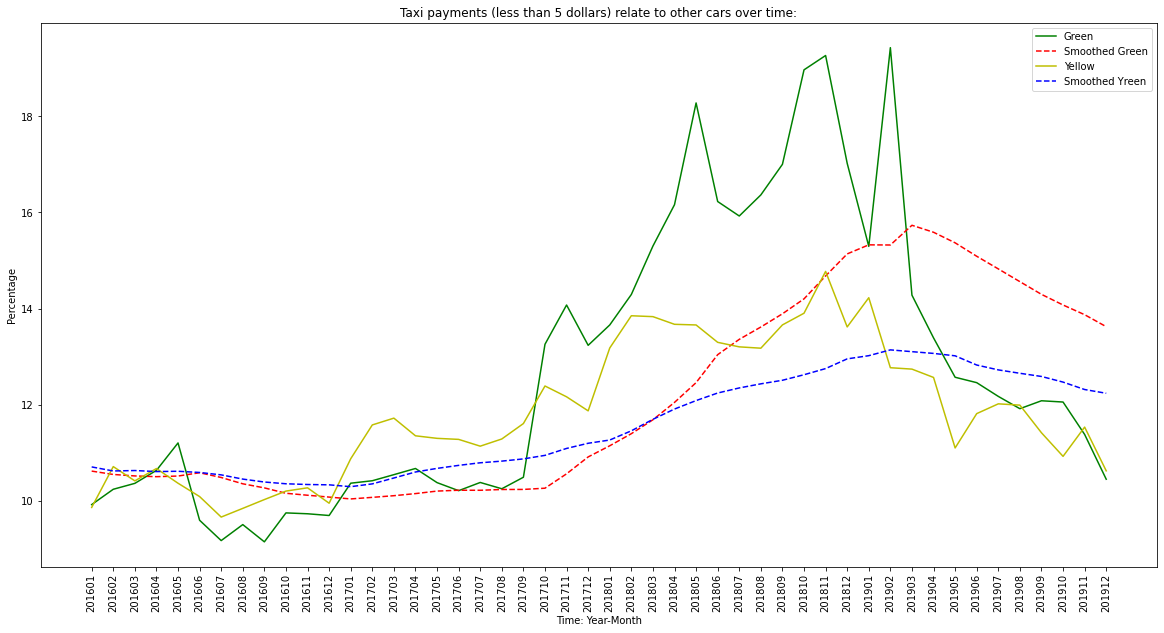

In [9]:
# Smoothing of plots
exp_green = ExponentialSmoothing(data_green.cym_percentage)
exp_model_green = exp_green.fit(smoothing_level=0.1)
result_green = exp_model_green.fittedvalues

exp_yellow = ExponentialSmoothing(data_yellow.cym_percentage)
exp_model_yellow  = exp_yellow .fit(smoothing_level=0.1)
result_yellow  = exp_model_yellow .fittedvalues

plt.figure(figsize=(20,10))

plt.plot(data_green['year-month'], data_green['cym_percentage'], 'g-', label="Green")
plt.plot(data_green['year-month'], result_green, 'r--', label="Smoothed Green")

plt.plot(data_yellow['year-month'], data_yellow['cym_percentage'], 'y-', label="Yellow")
plt.plot(data_yellow['year-month'], result_yellow, 'b--', label="Smoothed Yreen")

plt.xlabel("Time: Year-Month")
plt.ylabel("Percentage")
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.title('Taxi payments (less than 5 dollars) relate to other cars over time:')

plt.savefig('Taxi payments (less than 5 dollars) analysis.png', bbox_inches='tight')

plt.show()

![](Analysis1.png)

#####  Aggregate and fraction calculations:  
    COUNT(*)  
    GROUP BY  
        car_type  
        , pickup_year  
        , pickup_month  
        , payment_type  
    gives breakdown of number of payment transactions by car_type, pickup_year, pickup_month and payment_type  
    
    With this breakdown after GROUP BY, as a starting point: 
    --------------------------------------------------------
    SUM(COUNT(*)) OVER() gives sum total of ALL payment transactions (by ALL car types and ALL payment types for all time periods)  
    SUM(COUNT(*)) OVER(PARTITION BY car_type, payment_type) gives sum total of ALL payment transactions by car_type and payment_type  
    SUM(COUNT(*)) OVER(PARTITION BY car_type_type) gives sum total of ALL payment transactions by car_type
    SUM(COUNT(*)) OVER(PARTITION BY payment_type) gives sum total of ALL payment transactions by payment_type  
    

##### Analysis #2

- List the ***top 20 most frequent payment amounts under $5***, sorted highest to lowest.  

In [10]:
# List the top 20 most frequent payment amounts under $5, sorted highest to lowest.

query_top_20 = """ 
    SELECT 
        total_amount
        , COUNT(total_amount) AS freq
    FROM nyc_data
    WHERE
        total_amount BETWEEN 0 AND 5.0
    GROUP BY 
        total_amount
    ORDER BY freq DESC LIMIT 20;"""

df_top_20 = pd.read_sql(query_top_20, nyc_db)

print("Top 20 most frequent non-negative amounts under $5, sorted highest to lowest:")
print("-----------------------------------------------------------------------------")
df_top_20

Top 20 most frequent non-negative amounts under $5, sorted highest to lowest:
-----------------------------------------------------------------------------


,total_amount,freq
0,4.80,3877328
1,4.30,2269748
2,3.80,1182081
3,3.30,869930
4,0.00,155451
5,4.56,89168
6,5.00,68088
7,4.94,67418
8,4.55,61088
9,0.30,52920


##### Analysis #3  

- What ***_fraction of payments over $50_*** use a credit card?  

    a. Do certain types of “rides” elicit different behaviors?  

##### Analysis #4  

- What is the ***_number of credit card payments over $50_*** by car type?  

    a. What do you see?

In [11]:
# What fraction of payments over $50 use a credit card?
# a. Do certain types of “rides” elicit different behaviors?

# What is the number of credit card payments over $50 by car type?
# a. What do you see?

q_ = """WITH cte_ AS (
    SELECT 
        car_type
        , pickup_year
        , pickup_month
        , payment_type
        , COUNT(*) AS pcymCount
        , SUM(COUNT(*)) OVER () AS pcymTotal
        , SUM(COUNT(*)) OVER (PARTITION BY payment_type) AS pTotal
        , SUM(COUNT(*)) OVER (PARTITION BY car_type) AS cTotal  
        , SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type) AS pcTotal  
        , SUM(COUNT(*)) OVER (PARTITION BY car_type, pickup_year, pickup_month) AS cymTotal
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY payment_type)*100/(SUM(COUNT(*)) OVER()), 4) AS p_percentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type)*100/(SUM(COUNT(*)) OVER()), 4) AS c_percentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type)*100/(SUM(COUNT(*)) OVER(PARTITION BY car_type)), 4) AS pc_cpercentage
        , ROUND(SUM(COUNT(*)) OVER (PARTITION BY car_type, payment_type)*100/(SUM(COUNT(*)) OVER()), 4) AS pc_percentage
        , ROUND(COUNT(*)*100.0/(SUM(COUNT(*)) OVER (PARTITION BY car_type, pickup_year, pickup_month)), 4) AS cym_percentage
    FROM
        nyc_data
    WHERE
        total_amount > 50
    AND
        pickup_year BETWEEN 2016 AND 2019
    GROUP BY
        car_type
        , pickup_year
        , pickup_month
        , payment_type
)
SELECT
    car_type
    , pickup_year
    , pickup_month
    , pcymCount
    , pcymTotal
    , pTotal
    , pcTotal
    , cymTotal
    , p_percentage
    , c_percentage
    , pc_percentage
    , pc_cpercentage
    , cym_percentage
FROM
    cte_
WHERE
    payment_type = 1
;
"""
d_ = pd.read_sql(q_, nyc_db)

d_

,car_type,pickup_year,pickup_month,pcymCount,pcymTotal,pTotal,pcTotal,cymTotal,p_percentage,c_percentage,pc_percentage,pc_cpercentage,cym_percentage
0,green,2016,1,15084,20373542,15897634,662491,20868,78.0,4.0,3.0,75.0,72.2829
1,green,2016,2,14376,20373542,15897634,662491,19720,78.0,4.0,3.0,75.0,72.9006
2,green,2016,3,16384,20373542,15897634,662491,22580,78.0,4.0,3.0,75.0,72.5598
3,green,2016,4,17219,20373542,15897634,662491,23170,78.0,4.0,3.0,75.0,74.3159
4,green,2016,5,20123,20373542,15897634,662491,26688,78.0,4.0,3.0,75.0,75.4009
...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,yellow,2019,8,270572,20373542,15897634,15235143,354744,78.0,95.0,74.0,78.0,76.2725
92,yellow,2019,9,305227,20373542,15897634,15235143,389479,78.0,95.0,74.0,78.0,78.3680
93,yellow,2019,10,317739,20373542,15897634,15235143,406948,78.0,95.0,74.0,78.0,78.0785
94,yellow,2019,11,289183,20373542,15897634,15235143,365564,78.0,95.0,74.0,78.0,79.1060


In [12]:
d = d_

In [13]:
print()
print("Fraction of payments over $50 use a credit card for 'green' car type: \t {} %" \
      .format(d[(d['car_type'] == 'green')]['pc_cpercentage'].iloc[0]))
print()
print("---------------------------------------------------------------------")
print()
print("Fraction of payments over $50 use a credit card for 'yellow' car type: \t {} %" \
     .format(d[(d['car_type'] == 'yellow')]['pc_cpercentage'].iloc[0]))


Fraction of payments over $50 use a credit card for 'green' car type: 	 75.0 %

---------------------------------------------------------------------

Fraction of payments over $50 use a credit card for 'yellow' car type: 	 78.0 %


Clearly, more commuters on yellow cabs use credit card than on green cabs. When it comes to the dollar amount, there is more stark contrast in usage of credit card for **\$5** and lower fares than for **\$50** and above fares. This behaviors might be prompted by consideration that folks who tend to use green cab might come from poorer strata of the society who don't have an easy access to credit. A closely related fact could be that the green cabs operate (or might be licensed to operate) in poorer neighborhoods. But this differential almost vanished when it comes to large dollar amount usage. 


In [14]:
d['year-month'] = (d['pickup_year'].apply(str) + d['pickup_month'].apply(lambda x: str('{:02}'.format(x))))

In [15]:
data_green_ = d[['year-month', 'cym_percentage']][d.car_type == 'green']
data_yellow_ = d[['year-month', 'cym_percentage']][d.car_type == 'yellow']
data_green_['normalized_cym_percentage'] = (data_green_['cym_percentage'] - min(data_green_['cym_percentage']))/(max(data_green_['cym_percentage']) - min(data_green_['cym_percentage']))
data_yellow_['normalized_cym_percentage'] = (data_yellow_['cym_percentage'] - min(data_yellow_['cym_percentage']))/(max(data_yellow_['cym_percentage']) - min(data_yellow_['cym_percentage']))

/home/elkayvee/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


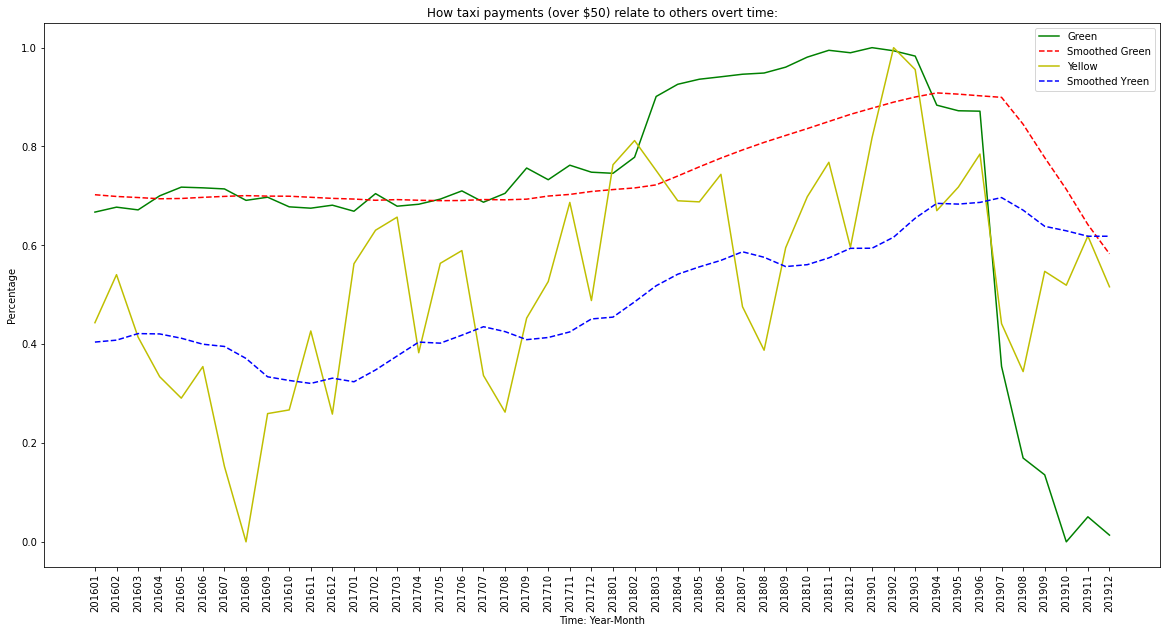

In [16]:
# Smoothing
exp_green_ = ExponentialSmoothing(data_green_.normalized_cym_percentage)
exp_model_green_ = exp_green_.fit(smoothing_level=0.1)
result_green_ = exp_model_green_.fittedvalues

exp_yellow_ = ExponentialSmoothing(data_yellow_.normalized_cym_percentage)
exp_model_yellow_  = exp_yellow_.fit(smoothing_level=0.1)
result_yellow_  = exp_model_yellow_.fittedvalues

plt.figure(figsize=(20,10))

plt.plot(data_green_['year-month'], data_green_['normalized_cym_percentage'], 'g-', label="Green")
plt.plot(data_green_['year-month'], result_green_, 'r--', label="Smoothed Green")

plt.plot(data_yellow_['year-month'], data_yellow_['normalized_cym_percentage'], 'y-', label="Yellow")
plt.plot(data_yellow_['year-month'], result_yellow_, 'b--', label="Smoothed Yreen")

plt.xlabel("Time: Year-Month")
plt.ylabel("Percentage")
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.title('How taxi payments (over $50) relate to others overt time:')

plt.savefig('Taxi payments (over $ 50) analysis.png', bbox_inches='tight')

plt.show()

Interestingly, over time, the credit card payments usage plummets for green cabs though continues to be used by yellow cab passengers, though at lowered rate.  The "smoothed" curves denote that behavior.  


#### Analysis #5  
- What is the mean **_fare per minute driven_**?    

    a. Has it gone up in accordance with the **_Consumer Price Index_**?  

In [17]:
columns_ = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_cpi = pd.read_csv("cpi.csv")[columns_]
df_cpi.rename(columns = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06', 'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}, inplace=True)
df_cpi=df_cpi[(df_cpi.Year >= 2016) & (df_cpi.Year < 2020)].reset_index(drop=True).set_index('Year')
df_cpi = df_cpi.unstack().reset_index(name='cpi')
df_cpi.rename(columns={'level_0': 'month', 'Year': 'year'}, inplace=True)
df_cpi['year-month'] = df_cpi['year'].apply(str) + df_cpi['month'].apply(str)#.apply(lambda x: str('{:02}'.format(x)))
df_cpi_ = df_cpi[['year-month','cpi']].sort_values('year-month')
df_cpi_['normalized_cpi'] = (df_cpi_['cpi'] - min(df_cpi_['cpi']))/(max(df_cpi_['cpi']) - min(df_cpi_['cpi']))


In [18]:
# What is the mean fare per minute driven?
# a. Has it gone up in accordance with the Consumer Price Index?
query_mfpm = '''
    SELECT
        -- coalesce(pickup_year,'') || coalese(pickup_month,'') AS year-month
        pickup_year
        , pickup_month
        , (total_amount/trip_duration) AS mean_fare_per_minute
    FROM 
        nyc_data
    WHERE
        pickup_year BETWEEN 2016 AND 2019
    GROUP BY
        pickup_year
        , pickup_month
    ;
'''

df_mfpm = pd.read_sql(query_mfpm, nyc_db)

df_mfpm.head().T

,0,1,2,3,4
pickup_year,2016.000000,2016.000000,2016.000000,2016.00000,2016.000000
pickup_month,1.000000,2.000000,3.000000,4.00000,5.000000
mean_fare_per_minute,1.094118,1.170635,2.909091,1.97389,1.128284


In [19]:
df_mfpm['year-month'] = (df_mfpm['pickup_year'].apply(str) + df_mfpm['pickup_month'].apply(lambda x: str('{:02}'.format(x))))

In [20]:
d = pd.merge(df_mfpm, df_cpi_, on='year-month')

In [21]:
d['normalized_mean_fare_per_minute'] = (d['mean_fare_per_minute'] - min(d['mean_fare_per_minute']))/(max(d['mean_fare_per_minute']) - min(d['mean_fare_per_minute']))

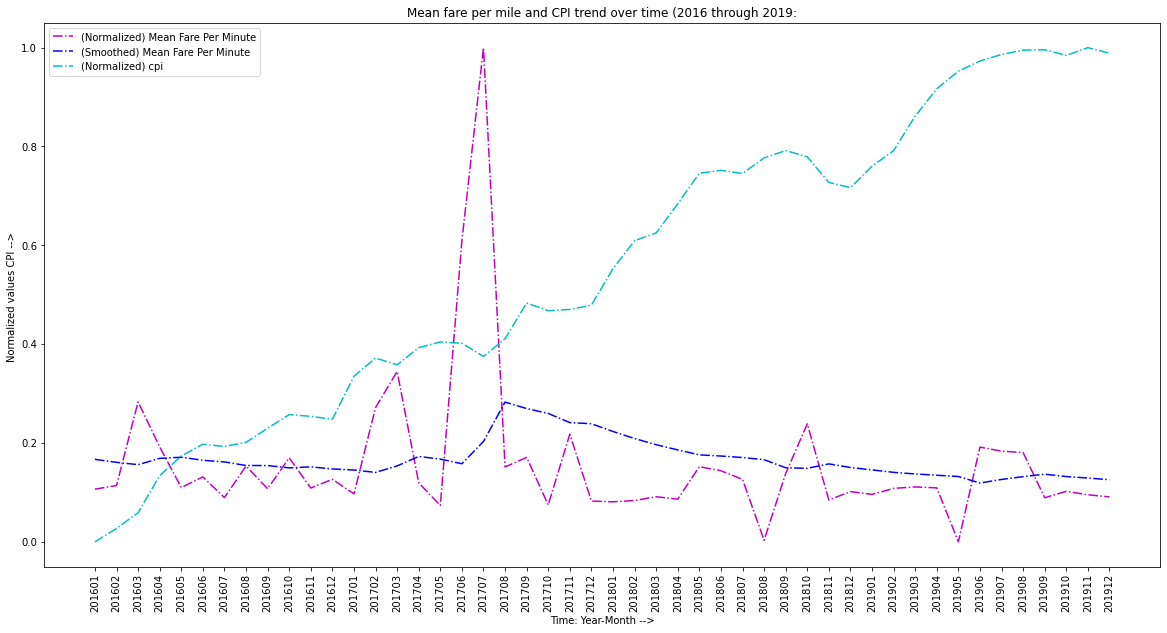

In [22]:
# Smoothing of mean_fare_per_minute
exp_mfpm = ExponentialSmoothing(d.normalized_mean_fare_per_minute)
exp_model_mfpm = exp_mfpm.fit(smoothing_level=0.1)
result_mfpm = exp_model_mfpm.fittedvalues

plt.figure(figsize=(20,10))

plt.plot(d['year-month'], d['normalized_mean_fare_per_minute'], 'm-.', label="(Normalized) Mean Fare Per Minute")
plt.plot(d['year-month'], result_mfpm, 'b-.', label="(Smoothed) Mean Fare Per Minute")
plt.plot(d['year-month'], d['normalized_cpi'], 'c-.', label="(Normalized) cpi")

plt.xlabel("Time: Year-Month -->")
plt.ylabel("Normalized values CPI --> ")
plt.legend(loc='best')
plt.xticks(rotation=90)
plt.title('Mean fare per mile and CPI trend over time (2016 through 2019:')

plt.savefig('Mean fare per mile Comparison with CPI over time.png', bbox_inches='tight')

plt.show()

It is interesting to note from the plot above that while CPI has notionally gone up from one period to next over all the years, barring the occasional spikes in the mean fare per mile has barely kept pace! It has largely remained flat despite the rise in cost of living as well as fule and tariff costs! It might perhaps be indicative of the increasing competition and crowding of the marketplace what with app-based alternatives cutting into the competition.

##### Analysis #6  

- What is the **_median_** of the taxi's **_fare per mile driven_**?  

    a. How does it relate to other “ride” platforms in 2019?


In [23]:
# What is the median of the taxi's fare per mile driven?
# a. How does it relate to other “ride” platforms in 2019?

sql_median = """WITH ordered_taxi_fare_per_mile AS (
    SELECT
        fare_per_mile,
        row_number() OVER (ORDER BY fare_per_mile) AS row_id,
        (SELECT COUNT(1) from nyc_dataPlus) AS ct
    FROM nyc_dataPlus
)
    SELECT AVG(fare_per_mile) AS median
    FROM ordered_taxi_fare_per_mile
    WHERE row_id BETWEEN ct/2.0 and ct/2.0 + 1
;
"""
df_median = pd.read_sql(sql_median, nyc_db)

print("the median of  the taxi's fare per mile driven:$ {:.2f} per mile".format(df_median.loc[0,'median']))

the median of  the taxi's fare per mile driven:
7.0625


In [ ]:
print("the median of  the taxi's fare per mile driven:$ {:.2f} per mile".format(df_median.loc[0,'median']))

##### 
- For different rides:  
_Median Fare per Mile_   


In [24]:
sqlmed_green = """WITH ordered_taxi_fare_per_mile AS (
    SELECT
               fare_per_mile
               , row_number() OVER ( ORDER BY fare_per_mile) AS row_id
               , (SELECT COUNT(1) from nyc_dataPlus_
                     WHERE 
                         pickup_year = 2019
                     AND
                         car_type = 'green') AS ct
    FROM nyc_dataPlus_
    WHERE
        pickup_year = 2019
    AND
        car_type = 'green'
)
    SELECT 
        AVG(fare_per_mile) AS median
    FROM ordered_taxi_fare_per_mile
    WHERE row_id BETWEEN ct/2.0 and ct/2.0 + 1
;
"""
dfmed_green = pd.read_sql(sqlmed_green, nyc_db)

print("Median fare per mile driven for 'green' car type is: $ {:.2f}".format(dfmed_green.loc[0,'median']))

Median fare per mile driven for 'green' car type is: $ {:.2f} 6.163522012578617


In [ ]:
print("Median fare per mile driven for 'green' car type is: $ {:.2f}".format(dfmed_green.loc[0,'median'])

In [25]:
sqlmed_yellow = """WITH _ordered_taxi_fare_per_mile AS (
    SELECT
        fare_per_mile
        , row_number() OVER ( ORDER BY fare_per_mile) AS row_id
        , (SELECT COUNT(1) from nyc_dataPlus_
                     WHERE 
                         pickup_year = 2019
                     AND
                         car_type = 'yellow') AS ct
    FROM nyc_dataPlus_
    WHERE
        pickup_year = 2019
    AND
        car_type = 'yellow'
)
    SELECT 
        AVG(fare_per_mile) AS median
    FROM _ordered_taxi_fare_per_mile
    WHERE row_id BETWEEN ct/2.0 and ct/2.0 + 1
;
"""
dfmed_yellow = pd.read_sql(sqlmed_yellow, nyc_db)

Median fare per mile driven for 'yellow' car type is: $ {:.2f} 8.479041916167665


In [ ]:
print("Median fare per mile driven for 'yellow' car type is: $ {:.2f}".format(dfmed_yellow.loc[0,'median']))

The overall **median** fare per mile is \$ 7.0625 - this includes ALL the data from 2016 through 2019.

The **_median_** fare per mile is higher in case of **yellow** car type (\$ 8.48)  than the case of **green**  taxis (\$ 6.16) in 2019!

##### Analysis #7  

- What is the ***_95 percentile_*** of the taxi's ***_average driving speed_*** in miles per hour?  
    a. Is that faster or slower than others?  
    

In [26]:
# What is the 95 percentile of the taxi's average driving speed in miles per hour?

sql = """WITH p AS (
    SELECT 
        car_type
        , driving_speed
        , AVG(driving_speed) AS avg_driving_speed
        , NTILE(95) OVER (ORDER BY driving_speed) AS percentile
    FROM 
        nycdata
    WHERE 
        trip_duration > 0
    GROUP BY 
        car_type
    HAVING driving_speed <= AVG(driving_speed)
           )
SELECT 
    car_type
    , avg_driving_speed
    , percentile
FROM p
;"""

df_95 = pd.read_sql(sql, nyc_db)

In [27]:
print("Average Driving Speed for ALL car_types: {:.2f}"\
      .format(pd.read_sql("SELECT AVG(driving_speed) as avg_speed FROM _nyc_dataSpeed WHERE trip_duration > 0;", nyc_db)\
              .loc[0, 'avg_speed']))
print()
print("95 Percentile of Average Driving Speed for ALL car_types: {:.2f} mph".format(df_95.loc[0, 'avg_driving_speed']))

Average Driving Speed for ALL car_types: 34.61

95 Percentile of Average Driving Speed for ALL car_types: 14.41 mph


In [28]:
# 95 Percentile of Average Driving Speed for car_type = 'green'

q_g95 = """
SELECT
    driving_speed
FROM 
    _nyc_dataSpeed
WHERE 
    car_type = 'green'
AND 
    trip_duration > 0
ORDER BY driving_speed ASC
LIMIT 1
OFFSET 
(
    SELECT
    COUNT(*)
    FROM 
        _nyc_dataSpeed
    WHERE 
        car_type = 'green'
    AND 
        trip_duration > 0
    GROUP BY
        car_type
    HAVING 
        driving_speed <= AVG(driving_speed)
) * 95/100 - 1;"""

df_g95 = pd.read_sql(q_g95, nyc_db)

print("Average Driving Speed for car_type = 'green': {:.2f}"\
      .format(pd.read_sql("SELECT AVG(driving_speed) as avg_green_speed FROM _nyc_dataSpeed WHERE car_type = 'green' AND trip_duration > 0;", nyc_db)\
              .loc[0, 'avg_green_speed']))

print("95 Percentile of Average Driving Speed for car_type = 'green': {:.2f}".format(df_g95.loc[0, 'driving_speed']))

Average Driving Speed for car_type = 'green': 14.41
95 Percentile of Average Driving Speed for car_type = 'green': 23.28


In [ ]:
# 95 Percentile of Average Driving Speed for car_type = 'yellow'

q_y95 = """
SELECT
    driving_speed
FROM 
    _nyc_dataSpeed
WHERE 
    car_type = 'yellow'
AND 
    trip_duration > 0
ORDER BY driving_speed ASC
LIMIT 1
OFFSET 
(
    SELECT
    COUNT(*)
    FROM 
        _nyc_dataSpeed
    WHERE 
        car_type = 'yellow'
    AND 
        trip_duration > 0
    GROUP BY
        car_type
    HAVING 
        driving_speed <= AVG(driving_speed)
) * 95/100 - 1;"""

df_y95 = pd.read_sql(q_y95, nyc_db)

print("Average driving speed for 'yellow' taxi is: {:.2f} mph"\
      .format(pd.read_sql("SELECT AVG(driving_speed) as avg_yellow_speed FROM _nyc_dataSpeed WHERE car_type = 'yellow' AND trip_duration > 0;", nyc_db)\
              .loc[0, 'avg_yellow_speed']))

print("95 percentile speed of average driving speed for 'yellow' taxi is: {:.2f} mph".format(df_y95.loc[0, 'driving_speed']))

The _95th percentile_ of _average driving speed_ for **green** car is 23.28 mph - as opposed to that for 'yellow' taxis that is - 23.743316


##### Analysis #8  

- What is the average ratio of the straight-line distance between the pickup and drop-off to the distance driven?  
    a. What is interesting about this compared year over year?  
    
    

In [3]:
sql_stl = """WITH ratio_ AS (SELECT stl_distance, trip_distance, ratio
           FROM nyc_dataRatio
           WHERE stl_distance != 0
           AND trip_distance != 0
           )
SELECT ROUND(avg(ratio),2) as avg_ratio
FROM ratio_
;
"""
df_stl = pd.read_sql(sql_stl, nyc_db)

In [4]:
print("the average ratio of the straight-line distance between the pickup and drop-off to the distance driven, where lat/lon details available , is: {:.2f}".format(df_stl.loc[0, 'avg_ratio']))

the average ratio of the straight-line distance between the pickup and drop-off to the distance driven, where lat/lon details available , is: 0.78


The breakdown of the ratio by the car type and over period of time indicates remarkable consistency for both green as well as yellow cabs.

In [5]:
sql_stl = """WITH _ratio AS (SELECT car_type, dropoff_year, dropoff_month, stl_distance, trip_distance, ratio
           FROM nyc_dataRatio
           WHERE stl_distance != 0
           ANd trip_distance != 0
           )
SELECT 
    car_type, 
    dropoff_year, 
    dropoff_month, 
    ROUND(avg(ratio),2)
FROM 
    _ratio
GROUP BY
    car_type, 
    dropoff_year, 
    dropoff_month    
;
"""
df_stl = pd.read_sql(sql_stl, nyc_db)

In [6]:
print("the average ratio, by car type, for the period for  which detail is available:")
print("\t", df_stl.head().T)

the average ratio, by car type, for the period for  which detail is available:
	                          0      1      2      3      4
car_type             green  green  green  green  green
dropoff_year          2016   2016   2016   2016   2016
dropoff_month            1      2      3      4      5
ROUND(avg(ratio),2)   0.77   0.78   0.78   0.77   0.77


The average ratio of straighline distance between the pickup and dropoff points has gone down over the month just a smidge indicating the increase in traffic congestion over the period resulting in taxi drivers taking longer distance but perhaps quicker routes as alternatives!  

It is instructive to keep in mind the fact that the latitude and longitude distances and therefore the straight-line computation is ONLY avaiable for first six months of 2016 after which it shifted to a location ID based system.  

##### Analysis #9  

- What is the average tip for rides from JFK in 2016 versus 2019 for each type of car?  


In [7]:
# JFK is PickupLocationID 132:

sql_tip = """
SELECT 
    car_type
    , pickup_year
    , AVG(tip_amount) as avg_tip
FROM 
    nyc_data 
WHERE 
    pulocationid = 132
AND 
    trip_distance != 0
AND 
    payment_type = 1
AND 
    pickup_year = 2016 
OR 
    pickup_year = 2019
GROUP BY
    car_type
    , pickup_year
;
"""
df_tip = pd.read_sql(sql_tip, nyc_db)

In [18]:
print("the average tip for rides in 'green' cab from JFK in 2016: $ {:.2f} "\
      .format(df_tip[(df_tip['car_type'] == 'green') & (df_tip['pickup_year'] == 2016)]['avg_tip'][0]))
print()
print("the average tip for rides in 'green' cab from JFK in 2019: $ {:.2f} "\
      .format(df_tip[(df_tip['car_type'] == 'green') & (df_tip['pickup_year'] == 2019)]['avg_tip'][1]))
print("------------------------------------------")
print("the average tip for rides in 'yellow' cab from JFK in 2016: $ {:.2f} "\
      .format(df_tip[(df_tip['car_type'] == 'yellow') & (df_tip['pickup_year'] == 2016)]['avg_tip'][2]))
print()
print("the average tip for rides in 'yellow' cab from JFK in 2019: $ {:.2f} "\
      .format(df_tip[(df_tip['car_type'] == 'yellow') & (df_tip['pickup_year'] == 2019)]['avg_tip'][3]))

the average tip for rides in 'green' cab from JFK in 2016: $ 9.05 

the average tip for rides in 'green' cab from JFK in 2019: $ 0.99 
------------------------------------------
the average tip for rides in 'yellow' cab from JFK in 2016: $ 9.25 

the average tip for rides in 'yellow' cab from JFK in 2019: $ 2.20 


It is clear from the above output that the average tip has fallen down from 2016 to 2019 for both the car types ('green' & 'yellow'), although the absolute amount is higher in case of 'yellow' car types than those of 'green' taxis. This could be result of the boroughs in which they operation mostly. Perhaps 'green' taxis operate in poorer areas than the 'yellow' ones!


#####  Analysis #10   

- "out-of-box" considrations - Weather impact, social impact, etc.  

There are substantial variations in ridership, taxi availability, trip distance, and pickup frequency for different time periods and weather conditions. 

Social impact: desireability of a location is incfreased just the same way as a good school district enhances the appeal of a neighbourhood. A good quality of life in terms of easy available access to transportation for mobility without the overhead of concomitant traffic congestion, good night life etc. can be used to measure social impact.  On the social impact front, extracting commuter-specific destination hotspots from trip destination data – comparing the borough taxi service etc. can give an inkling of the _happening_ places in and around the city, the presence or absence of _night life_ based on the pickup/dropoff hotspots etc. can be a barometer of the social impact of the taxi service analysis.

It is also possible to associate starting and end points of taxi trips with requirements of individual groups of people and even social inequalities. Comparing the average fare per mile, tipping behavirs of the commuters between specific pairs of locationIDs can help gauge the social index around the destinations/origins of traffic.  

Start and end points of trips, as well as the volumes in conjunction with something like bike sharing data, for example, can help us come up with a spatiotemporal assigning procedure for **_areas of influence_** around the city. 



In [ ]:
# Average daily count of taxi trips by car_type:
sql_snow = """
SELECT 
    car_type
    , COUNT(1) AS cnt
FROM 
    nyc_dataWeather 
GROUP BY
    car_type
    , SNOW_LEVEL
;
"""
df_snow = pd.read_sql(sql_snow, nyc_db)

df_snow.head().T

In [ ]:
x_ = df_snow[df_snow['car_type'] == 'green']['SNOW_LEVEL'].tolist()
y_green_  = df_snow[df_snow['car_type'] == 'green']['cnt'].tolist()
y_yellow_ = df_snow[df_snow['car_type'] == 'yellow']['cnt'].tolist()

dfs_ = pd.DataFrame(data={'x': x_, 'y_green': y_green_, 'y_yellow': y_yellow_})

dfs__ = pd.melt(dfs_, id_vars = "x")

fig = plt.figure()
sns.factorplot(x = 'x', y='value', 
               hue = 'class',data=dfs__, kind='bar')

plt.title('Effect of snow precipitation on number of trips')

plt.savefig('Effect of snow precipitation on number of trip.png', bbox_inches='tight')
plt.show()

In [ ]:
# Average daily count of taxi trips by car_type:

sql_prcp = """
SELECT 
    car_type
    , COUNT(1) AS cnt
FROM 
    nyc_dataWeather 
GROUP BY
    car_type
    , PRCP_LEVEL
;
"""
df_prcp = pd.read_sql(sql_prcp, nyc_db)

df_prcp.head().T

In [ ]:
x = df_prcp[df_prcp['car_type'] == 'green']['SNOW_LEVEL'].tolist()
y_green  = df_prcp[df_prcp['car_type'] == 'green']['cnt'].tolist()
y_yellow = df_prcp[df_prcp['car_type'] == 'yellow']['cnt'].tolist()
col_one_arr = df['one'].to_numpy()

dfs = pd.DataFrame(data={'x': x, 'y_green': y_green, 'y_yellow': y_yellow})

dfs1 = pd.melt(dfs, id_vars = "x")

fig = plt.figure()
sns.catplot(x = 'x', y='value', hue = 'class',data=dfs1, kind='bar')
plt.title('Effect of rain precipitation on number of trips')

plt.savefig('Effect of rain precipitation on number of trip.png', bbox_inches='tight')
plt.show()

##### Analysis #11   

_Data-driven_ proposal to increase NYC denizen's happiness and satisfaction with car service:  
The factors that can contribute to happiness of folks who don't want to (be forced to) own a personal car in an urban jungle like New York can be listed as:
- Easy availability of the vehicles for street-hailing  
- At the same time, less traffic congestion (i.e., quick travel) for  cheap

The data captured form the NYC-TLC has the details that can be analyzed for purposes like avoiding traffics, lower rate where services are not functioning more frequency than a cab on crown location etc. E-Hail apps are not expected to offer considerable improvements at all times, but rather when both adequate taxi supply and demand occur simultaneously. This can aid supplimentary transport planning and service.  Details like most pickups, time, distance, airport timings (or other landmark timings/availability etc.), where taxis are used, when taxis are used can easily be inferred from the data. In order to provide very good taxi service and plan for effective integration in city transportation system, it’s very important to **_analyse the demand for taxi transportation_**. 

We can analyse the factors for demand for taxis, find the most pickups, drop-offs of public based on their location, time of most traffic etc.

Analysis on Region through information allied with location like PickUp Latitude, PickUp Longitude, DropOff Latitude and DropOff Longitude, Pickup LocationID, DropOffLocationID can easily give analysis of the most PickUp locations/the DropOff
locations. This will help to provide more taxis on the most PickUp location and so on. 

Then there is an opportunity to quantify the Total Pick-ups and Drop-offs by Time of Day based on location -  analysis based on the total PickUp and DropOff for a day per hour and location. 



